# Bayesian Naive Bayes Implementation

# Imports

In [653]:
import os
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns

rd = np.random.RandomState(23523)

# Bayesian Naive Bayes

In [688]:
# READING DATA
df = pd.read_csv('../data/votesDataset.csv')
print('Shape:', df.shape)

X = df.iloc[:, 1:]
y = df.iloc[:, [0]].replace({'republican': 0, 'democrat': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64852)
df.head()

Shape: (435, 17)


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,republican,0,1,0,1,1,1,0,0,0,1,0,1,1,0,0,1
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,0,0,1
2,democrat,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0
3,democrat,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1
4,democrat,1,1,1,0,1,1,0,0,0,0,1,0,1,0,1,1


In [689]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

display(X_train[:5, :])
display(y_train[:5, :])

array([[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]], dtype=int64)

array([[1],
       [0],
       [1],
       [1],
       [1]], dtype=int64)

In [690]:
class BayesianNaiveBayes():
    def __init__(self):        
        pass

    def set_priori_params(
        self,
        dirichlet_alpha,
        beta_a,
        beta_b
    ):
        self.dirichlet_alpha = dirichlet_alpha
        self.beta_a = beta_a
        self.beta_b = beta_b

    def fit(self, X, y):

        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        classes = np.unique(y)
        self.class_to_idx_dict = {classes[i]: i for i in range(len(classes))}

        n_features = X.shape[1]

        self.pi = np.zeros((len(classes), 1)) # n_classes x 1
        self.theta = np.zeros((len(classes), n_features)) # n_classes x n_features
        

        for label in classes:
            c = self.class_to_idx_dict[label]
            X_class = X[np.where(y==label)[0], :]
            y_class = y[np.where(y==label)[0], :]


            # SETTING PI
            N_c = y_class.shape[0]
            N = y.shape[0]
            dir_alpha = self.dirichlet_alpha[c]
            dir_sum_alphas = np.sum(self.dirichlet_alpha)

            self.pi[c] = (N_c + dir_alpha) / (N + dir_sum_alphas)


            # SETTING THETA
            N_dc = np.sum(X_class, axis=0)
            
            self.theta[c] = (N_dc + self.beta_b) / (N_c + self.beta_a + self.beta_b)


    def predict(self, X):

        idx_to_class = {v: k for k, v in self.class_to_idx_dict.items()}
        prob_classes = np.zeros((X.shape[0], len(idx_to_class)))

        for i, label in enumerate(idx_to_class.values()):

            c = self.class_to_idx_dict[label]
            pi = self.pi[c]
            theta = self.theta[[c]]
            
            for idx, x in enumerate(X):
                first_term = np.log(pi)
                second_term = np.sum(np.log(theta, where=x.astype(bool)))
                third_term = np.sum(np.log(1 - theta, where=np.abs(x - 1).astype(bool)))
                
                pred = first_term + second_term + third_term
                prob_classes[idx, i] = pred
                

        preds = []

        for i in range(prob_classes.shape[0]):
            argmax = np.argmax(prob_classes[i, :])
            preds.append(idx_to_class[argmax])
            
        return np.array(preds).reshape(-1, 1)

In [691]:
my_bnb = BayesianNaiveBayes()
my_bnb.set_priori_params(
    dirichlet_alpha=[1, 2],
    beta_a=1,
    beta_b=0
)

In [692]:
# FIT
my_bnb.fit(X_train, y_train)

# PREDICTION
y_pred = my_bnb.predict(X_test)
cf = confusion_matrix(y_test, y_pred)
cf

array([[37,  7],
       [11, 76]], dtype=int64)

<AxesSubplot:>

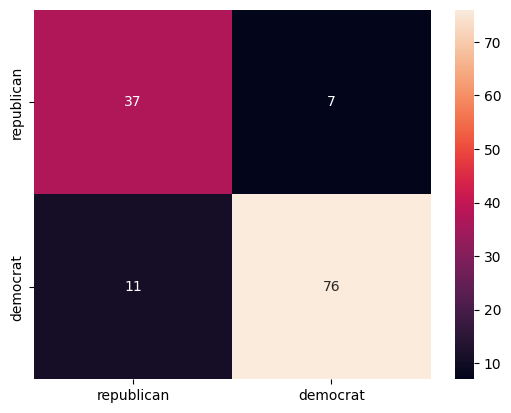

In [693]:
sns.heatmap(
    cf, 
    annot=True, 
    xticklabels=['republican', 'democrat'], 
    yticklabels=['republican', 'democrat']
)